# Group 11 
Names                                - ID
<br>
Amr Hesham                       - 20210280
<br>
Mahmoud Osama                    - 20210367
<br>
Youssef Abdelghfar               - 20210474
<br>
Hadeer Wael                      - 20210444

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [2]:
data = fetch_openml('CIFAR_10_small', version=1)
X = data.data / 255.0  # Normalize the data to [0, 1]
y = data.target.astype(int)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Standardize the data
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_std = standardize(X)

In [4]:
def compute_covariance_matrix(X):
    n_samples = X.shape[0]
    mean_centered = X - np.mean(X, axis=0)
    covariance_matrix = np.dot(mean_centered.T, mean_centered) / (n_samples - 1)
    return covariance_matrix

covariance_matrix = compute_covariance_matrix(X_std)

In [5]:
def compute_eigenvalues_and_eigenvectors(A, num_eigenvalues, tolerance=1e-10, max_iterations=1000):
    n = A.shape[0]
    eigenvalues = []
    eigenvectors = []
    epsilon = 1e-12  # Small constant to avoid division by zero

    for _ in range(num_eigenvalues):
        b_k = np.random.rand(n)
        b_k /= (np.linalg.norm(b_k) + epsilon)  # Initial normalization

        for iteration in range(max_iterations):
            # Power iteration
            b_k1 = np.dot(A, b_k)
            b_k1_norm = np.linalg.norm(b_k1) + epsilon

            if np.abs(b_k1_norm - np.linalg.norm(b_k)) < tolerance:
                break

            b_k = b_k1 / b_k1_norm

        # Rayleigh quotient for eigenvalue
        eigenvalue = np.dot(b_k.T, np.dot(A, b_k))
        eigenvalues.append(eigenvalue)
        eigenvectors.append(b_k)

        # Deflate the matrix
        A = A - eigenvalue * np.outer(b_k, b_k)
        A = np.clip(A, -1e12, 1e12)  # Clip values to avoid numerical instability

    return np.array(eigenvalues), np.array(eigenvectors).T

In [6]:
# Compute top k eigenvalues and eigenvectors
top_k = 60
eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(covariance_matrix, num_eigenvalues=top_k)

In [7]:
def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

In [8]:
sorted_eigenvalues, sorted_eigenvectors = sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors)

In [9]:
# Function to project data and reconstruct
def project_and_reconstruct(X, eigenvectors, k):
    principal_components = eigenvectors[:, :k]
    X_projected = np.dot(X, principal_components)  # Project the data
    X_projected = X_projected / np.std(X_projected, axis=0)
    X_reconstructed = np.dot(X_projected, principal_components.T)  # Reconstruct the data
    return X_projected, X_reconstructed

In [10]:
k_values = [10, 20, 30, 40]

In [11]:
# If X_std is a DataFrame, convert to a NumPy array
X_std = X_std.to_numpy()

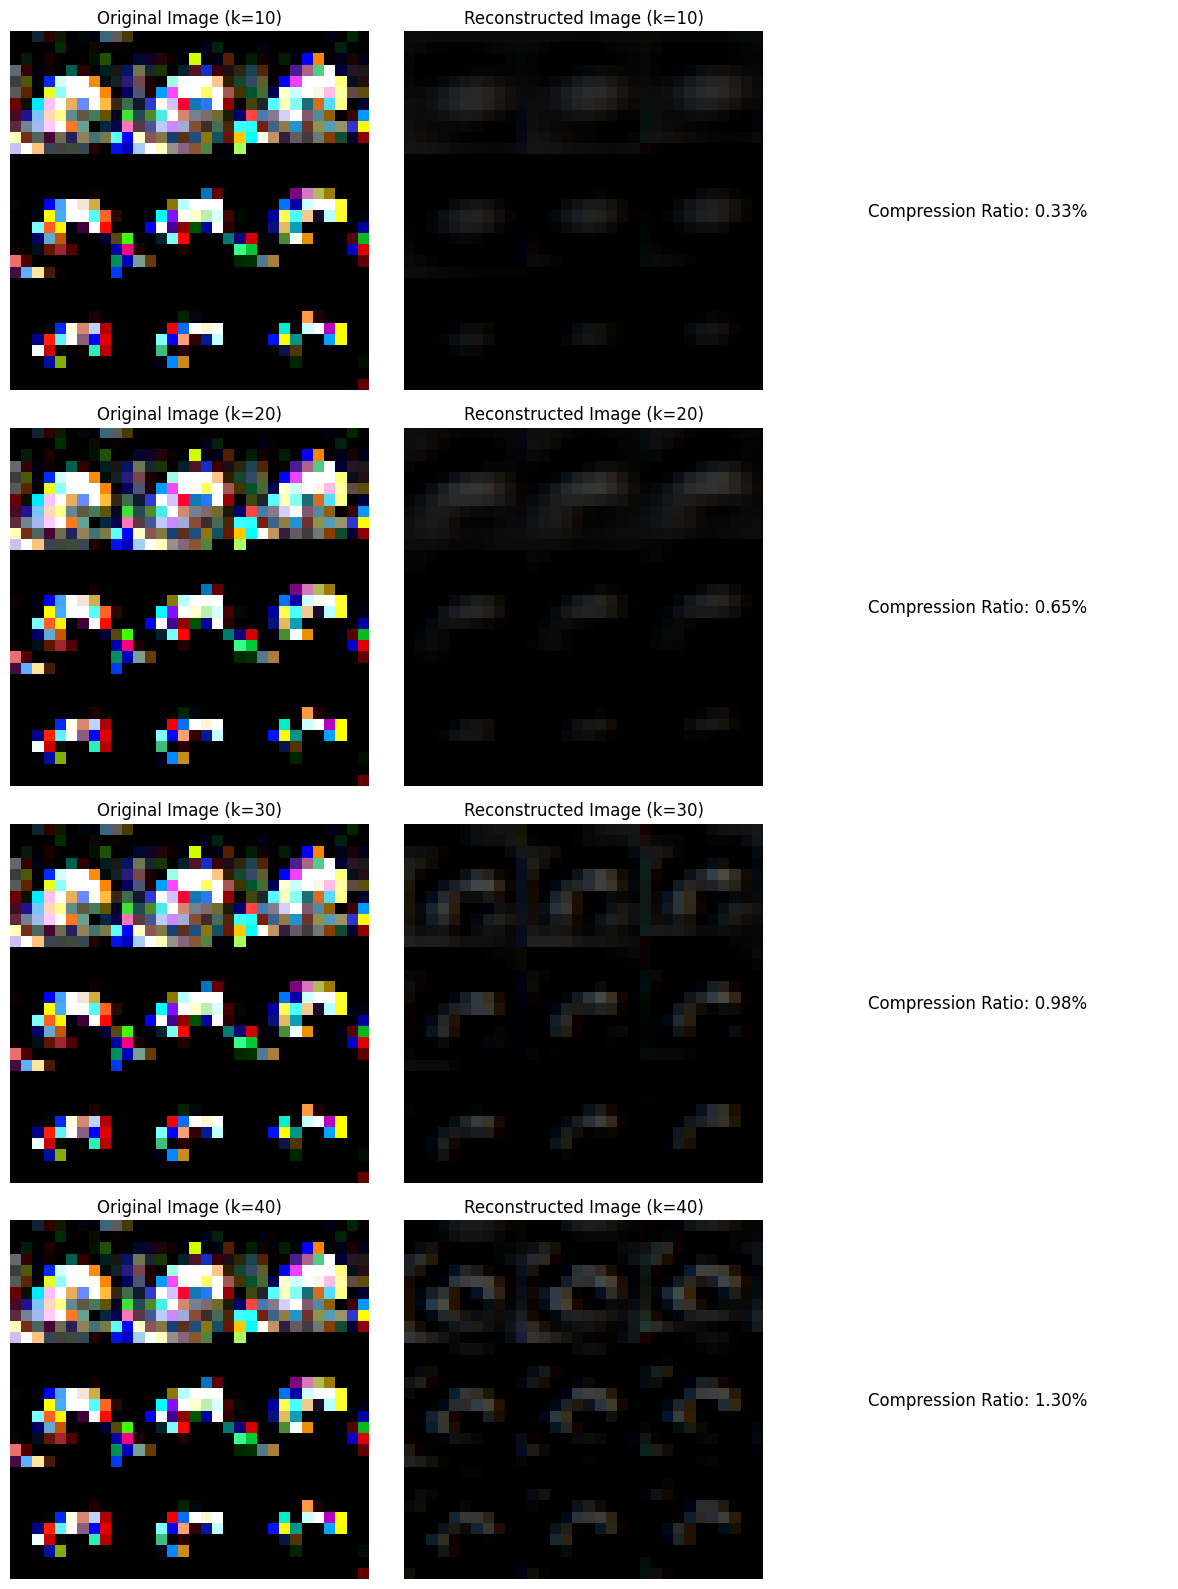

In [12]:
# Visualize and analyze for each k
fig, axes = plt.subplots(len(k_values), 3, figsize=(12, len(k_values) * 4))
for i, k in enumerate(k_values):
    X_projected, X_reconstructed = project_and_reconstruct(X_std, sorted_eigenvectors, k)

    # Select a sample image (e.g., the first image)
    original_image = X_std[0].reshape(32, 32, 3)  # Adjusted for CIFAR-10
    reconstructed_image = X_reconstructed[0].reshape(32, 32, 3)  # Adjusted for CIFAR-10

    # Ensure that the images are correctly scaled to [0, 1]
    original_image = np.clip(original_image, 0, 1)
    reconstructed_image = np.clip(reconstructed_image, 0, 1)

    # Plot original, compressed, and reconstructed images
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(f'Original Image (k={k})')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_image)
    axes[i, 1].set_title(f'Reconstructed Image (k={k})')
    axes[i, 1].axis('off')

    # Display the compression ratio
    compression_ratio = k / X_std.shape[1]
    axes[i, 2].text(0.5, 0.5, f'Compression Ratio: {compression_ratio:.2%}',
                    fontsize=12, ha='center', va='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# K-Means++ Initialization
def k_means_plus_plus(X, k):
    centroids = [X[np.random.choice(range(len(X)))]]  # First centroid randomly selected
    for _ in range(1, k):
        dist_sq = np.min([np.linalg.norm(X - c, axis=1)**2 for c in centroids], axis=0)
        prob = dist_sq / np.sum(dist_sq)
        new_centroid = X[np.random.choice(range(len(X)), p=prob)]
        centroids.append(new_centroid)
    return np.array(centroids)

In [14]:
# K-Means clustering
def k_means(X, k, iters=100):
    centroids = k_means_plus_plus(X, k)
    for _ in range(iters):
        # Compute distances
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, labels

In [15]:
# Hamming Network
def hamming_network_cluster(input_vector, centroids):
    weights_matrix = centroids / 2
    n = input_vector.shape[0]
    theta = -n / 3  # Adjusted bias
    net_input = np.dot(weights_matrix, input_vector.T) + theta
    net_input_abs = np.abs(net_input)
    return np.argmin(net_input_abs, axis=0)

In [16]:
# Evaluate accuracy
def evaluate_accuracy(predictions, targets):
    return np.mean(predictions == targets)

In [23]:
# Perform clustering on reconstructed data
X_projected, X_reconstructed = project_and_reconstruct(X_std, sorted_eigenvectors, 20)

centroids, labels = k_means(X_reconstructed, k=10)
winner_clusters = [
    hamming_network_cluster(X_reconstructed[i], centroids)
    for i in range(X_reconstructed.shape[0])
]
accuracy = evaluate_accuracy(winner_clusters, labels)
print("Accuracy on PCA-reconstructed data:", accuracy)

Accuracy on PCA-reconstructed data: 0.8358


In [18]:
centroids, labels = k_means(X_std, k=10)
winner_clusters = [
    hamming_network_cluster(X_std[i], centroids)
    for i in range(X_std.shape[0])
]
accuracy = evaluate_accuracy(winner_clusters, labels)
print("Accuracy on Original data:", accuracy)

Accuracy on Original data: 0.3558


Process Flow:
1.	First Centroid Selection: The first centroid is selected randomly from the dataset.
2.	Distance Calculation: For each subsequent centroid, the squared distances from all points to the nearest centroid are computed.
3.	Centroid Selection with Probability: A new centroid is selected from the data points based on a probability distribution proportional to these squared distances.
4.	Repeat: This process is repeated until `k` centroids are selected.


Results:

•	The function returns an array containing the `k` centroids chosen by the K-Means++ initialization method.

•	The centroids are selected such that they are spread out across the dataset, improving the convergence and performance of subsequent K-Means clustering operations.

•	The model achieved an accuracy of 83.6% when evaluated after dimensionality reduction using PCA.

•	The model achieved an accuracy of 35.6% when evaluated on the original data.
